Engineer: Adeola Odunewu
Intern: FlipRobo LLC DS1123
Project: Fraud Report Classification

In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
import statsmodels.api as sm



import matplotlib.pyplot as plt
from sklearn.svm import SVR, SVC
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from statsmodels.formula.api import ols
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

warnings.filterwarnings("ignore", message=".*deprecated.*")

In [2]:
# File paths for the CSV files
url = 'https://raw.githubusercontent.com/FlipRoboTechnologies/ML_-Datasets/main/Insurance%20Claim%20Fraud%20Detection/Automobile_insurance_fraud.csv'

# Read CSV files into DataFrame objects
df = pd.read_csv(url)  

In [3]:
# Showing the first 5 column.
df.head()

,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,2,YES.1,71610,6510,13020,52080,Saab,92x,2004,Y
0,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
1,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
2,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
3,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
4,256,39,104594,12-10-2006,OH,250/500,1000,1351.10,0,478456,...,2,NO,64100,6410,6410,51280,Saab,95,2003,Y


In [10]:
# Showing the details.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   328                       999 non-null    int64  
 1   48                        999 non-null    int64  
 2   521585                    999 non-null    int64  
 3   17-10-2014                999 non-null    object 
 4   OH                        999 non-null    object 
 5   250/500                   999 non-null    object 
 6   1000                      999 non-null    int64  
 7   1406.91                   999 non-null    float64
 8   0                         999 non-null    int64  
 9   466132                    999 non-null    int64  
 10  MALE                      999 non-null    object 
 11  MD                        999 non-null    object 
 12  craft-repair              999 non-null    object 
 13  sleeping                  999 non-null    object 
 14  husband   

To restructure the dataset and assign appropriate names to the attributes, these follow steps were taking:

Define a dictionary mapping the current column indices to the appropriate attribute names.
Rename the columns using this dictionary.

Necessary feature engineering like these will ensure the data is appropriately structured.

In [3]:
# Renaming df in the existing DataFrame:
df.rename(columns={'328': 'months_as_customer', 
                   '48': 'age',
                   '521585': 'policy_number',
                   '17-10-2014': 'policy_bind_date',
                   'OH': 'policy_state',
                   '250/500': 'policy_csl',
                   '1000': 'policy_deductable',
                   '1406.91': 'policy_annual_premium',
                   '0': 'umbrella_limit',
                   '466132': 'insured_zip',
                   'MALE': 'insured_sex',
                   'MD': 'insured_education_level',
                   'craft-repair': 'insured_occupation',
                   'sleeping': 'insured_hobbies',
                   'husband': 'insured_relationship',
                   '53300': 'capital-gains',
                   '0.1': 'capital-loss',
                   '25-01-2015': 'incident_date',
                   'Single Vehicle Collision': 'incident_type',
                   'Side Collision': 'collision_type',
                   'Major Damage': 'incident_severity',
                   'Police': 'authorities_contacted',
                   'SC': 'incident_state',
                   'Columbus': 'incident_city',
                   '9935 4th Drive': '1ncident_location',
                   '5': 'incident_hour_of_the_day',
                   '1': 'number_of_vehicles_involved',
                   'YES': 'property_damage',
                   '1.1': 'bodily_injuries',
                   '2': 'witnesses',
                   'YES.1': 'police_report_available',
                   '71610': 'total_claim_amount',
                   '6510': 'injury_claim',
                   '13020': 'property_claim',
                   '52080': 'vehicle_claim',
                   'Saab': 'auto_make',
                   '92x': 'auto_model',
                   '2004': 'auto_year',
                   'Y': 'fraud_reported'}, inplace=True)

In [22]:
# Showing the Last 5 column.
df.tail()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
994,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
995,285,41,186934,05-01-2014,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
996,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
997,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N
998,456,60,556080,11-11-1996,OH,250/500,1000,766.19,0,612260,...,3,?,5060,460,920,3680,Mercedes,E400,2007,N


In [23]:
# Identifying missing values
missing_data = df.isnull().sum()
print(missing_data)

months_as_customer              0
age                             0
policy_number                   0
policy_bind_date                0
policy_state                    0
policy_csl                      0
policy_deductable               0
policy_annual_premium           0
umbrella_limit                  0
insured_zip                     0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
capital-gains                   0
capital-loss                    0
incident_date                   0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted          91
incident_state                  0
incident_city                   0
1ncident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                 0
witnesses     

In [4]:
# Selecting columns with object dtype (typically strings)
cate_df = df.select_dtypes(include=['object'])

# Selecting columns with numeric dtypes (integers and floats)
numeric_df = df.select_dtypes(include=['int64', 'float64'])


In [10]:
# Generate descriptive statistics for categorical columns
cate_df.describe()

,policy_bind_date,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_date,incident_type,...,incident_severity,authorities_contacted,incident_state,incident_city,1ncident_location,property_damage,police_report_available,auto_make,auto_model,fraud_reported
count,999,999,999,999,999,999,999,999,999,999,...,999,908,999,999,999,999,999,999,999,999
unique,950,3,3,2,7,14,20,6,60,4,...,4,4,7,7,999,3,3,14,39,2
top,05-08-1992,OH,250/500,FEMALE,JD,machine-op-inspct,reading,own-child,02-02-2015,Multi-vehicle Collision,...,Minor Damage,Police,NY,Springfield,6608 MLK Hwy,?,?,Dodge,RAM,N
freq,3,351,350,537,161,93,64,183,28,419,...,354,291,262,157,1,360,343,80,43,753


In [58]:
# Generate descriptive statistics for numeric columns
numeric_df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,999.000000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,203.829830,38.938939,546263.326326,1136.136136,1256.255495,1.102102e+06,501249.605606,25097.897898,-26820.520521,11.650651,1.839840,0.991992,1.486486,52743.073073,7434.344344,7393.943944,37914.784785,2005.104104
std,115.103809,9.140370,257190.576942,612.155989,244.243187,2.298293e+06,71728.919924,27871.869471,28105.366259,6.951671,1.019044,0.820538,1.111773,26408.011569,4883.309038,4823.859773,18890.397013,6.018773
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.000000,0.000000,0.000000,100.000000,0.000000,0.000000,70.000000,1995.000000
25%,115.500000,32.000000,335913.500000,500.000000,1089.185000,0.000000e+00,448373.000000,0.000000,-51500.000000,6.000000,1.000000,0.000000,1.000000,41775.000000,4290.000000,4440.000000,30275.000000,2000.000000
50%,199.000000,38.000000,533940.000000,1000.000000,1257.040000,0.000000e+00,466498.000000,0.000000,-24100.000000,12.000000,1.000000,1.000000,1.000000,57970.000000,6780.000000,6750.000000,42080.000000,2005.000000
75%,276.000000,44.000000,759459.500000,2000.000000,1415.710000,0.000000e+00,603254.000000,51000.000000,0.000000,17.000000,3.000000,2.000000,2.000000,70550.000000,11310.000000,10870.000000,50775.000000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.000000,2.000000,3.000000,114920.000000,21450.000000,23670.000000,79560.000000,2015.000000


<Axes: xlabel='authorities_contacted', ylabel='count'>

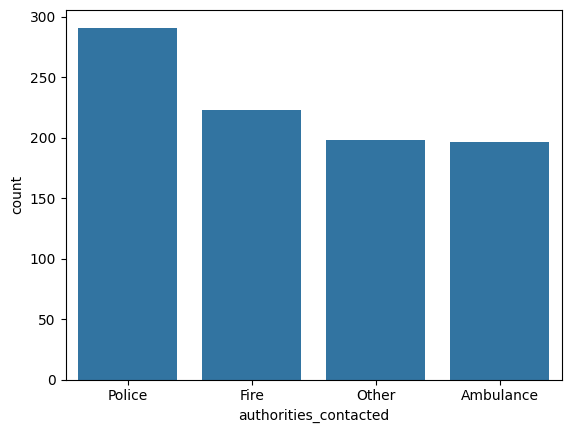

In [59]:
# Visualizing the distribution of 'authorities_contacted' using a count plot 
# (to determine the best way to handle the missing values)
sns.countplot(data=df, x=df['authorities_contacted'])

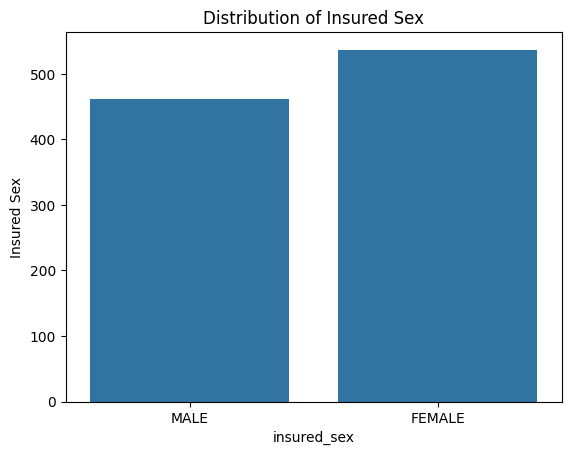

In [10]:

# Plotting a box plot for Insured Sex
sns.countplot(data = df, x = 'insured_sex')
plt.title('Distribution of Insured Sex')
plt.ylabel('Insured Sex')
plt.show()


Based on the fairly distributed distribution of authorities_contacted, the 91 missing values will be replaced by the mode using the imputation method.

In [5]:
# List of columns with categorical data
categorical_columns = df.select_dtypes(include=['object'])

# Iterate over each column and replace missing values with the mode (This chunk of code is used for efficiency instead of the one commented out below)
for column in categorical_columns:
    mode_value = df[column].mode().iloc[0]  # Calculate the mode value of the column
    df[column].fillna(mode_value, inplace=True)  # Fill missing values with the mode

''' # Impute missing values in 'authorities_contacted' with the mode
mode_authorities_contacted = df['authorities_contacted'].mode()[0]
df['authorities_contacted'].fillna(mode_authorities_contacted, inplace=True) '''

" # Impute missing values in 'authorities_contacted' with the mode\nmode_authorities_contacted = df['authorities_contacted'].mode()[0]\ndf['authorities_contacted'].fillna(mode_authorities_contacted, inplace=True) "

In [6]:
# Strip leading whitespace and convert fraud_reported column to numeric values
df['fraud_reported'] = df['fraud_reported'].str.strip().replace({'N': 0, 'Y': 1})

In [9]:

# Identify object columns
object_columns = df.select_dtypes(include=['object']).columns

# Convert object columns to categorical type
for col in object_columns:
    df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=False)

# The `ordered=False` parameter prevents pandas from treating categorical variables as ordered by default.

In [7]:
# Counting the number of missing values in the column
# Identifying missing values
missing_datak = df.isnull().sum()
print(missing_datak)

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
1ncident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

In [9]:
# Count the number of unique values in each column and create a DataFrame with the results
unique_value_counts = df.nunique().to_frame("Unique Values")
print(unique_value_counts)

                             Unique Values
months_as_customer                     391
age                                     46
policy_number                          999
policy_bind_date                       950
policy_state                             3
policy_csl                               3
policy_deductable                        3
policy_annual_premium                  990
umbrella_limit                          11
insured_zip                            994
insured_sex                              2
insured_education_level                  7
insured_occupation                      14
insured_hobbies                         20
insured_relationship                     6
capital-gains                          338
capital-loss                           354
incident_date                           60
incident_type                            4
collision_type                           4
incident_severity                        4
authorities_contacted                    4
incident_st

In [ ]:
Univariate Analysis:

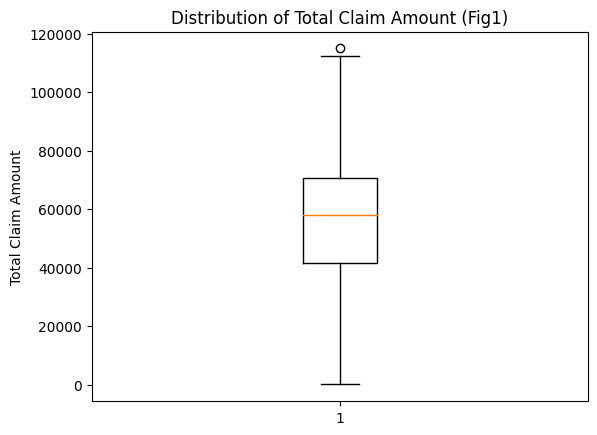

In [71]:
# Plotting a box plot for total_claim_amount
plt.boxplot(df['total_claim_amount'])
plt.title('Distribution of Total Claim Amount (Fig1)')
plt.ylabel('Total Claim Amount')
plt.show()

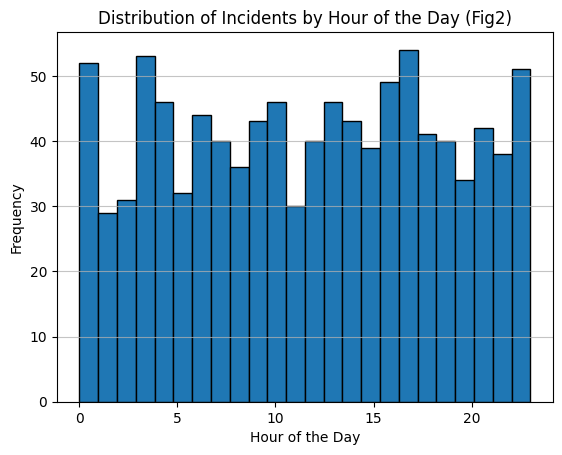

In [72]:

# Plotting a histogram for incident_hour_of_the_day
plt.hist(df['incident_hour_of_the_day'], bins=24, edgecolor='black')
plt.title('Distribution of Incidents by Hour of the Day (Fig2)')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()



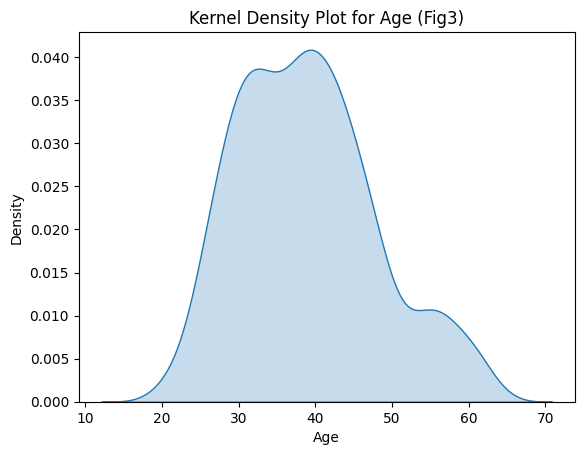

In [73]:
# Plotting kernel density plot for age
sns.kdeplot(data=df['age'], fill=True)
plt.title('Kernel Density Plot for Age (Fig3)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

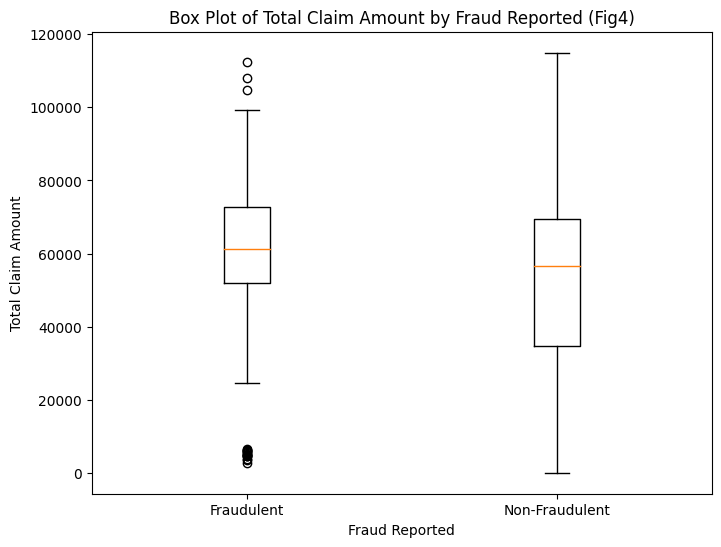

In [74]:
# Plotting a box plot for 'total_claim_amount' with respect to 'fraud_reported'
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['fraud_reported'] == 'Y']['total_claim_amount'],
             df[df['fraud_reported'] == 'N']['total_claim_amount']],
            labels=['Fraudulent', 'Non-Fraudulent'])
plt.title('Box Plot of Total Claim Amount by Fraud Reported (Fig4)')
plt.xlabel('Fraud Reported')
plt.ylabel('Total Claim Amount')
plt.show()

The analysis entails examining the distribution of total claim amounts, incident hours of the day, age distribution, and comparison of total claim amounts between fraudulent and non-fraudulent claims.

Total Claim Amount Distribution Analysis (Fig 1):
The distribution of total claim amounts displays a slight positive skew, indicating more occurrences of lower claim amounts compared to higher ones. Outliers are identified through box plots, suggesting the presence of unusually high and low claim amounts.
Average Incident Hour of the Day (Fig 2):
On average, incidents occur around 11 hours of the day. No outlier handling or transformation is required for this analysis.
Age Distribution Analysis (Fig 3):
The age distribution is symmetric with a right tail. No specific outlier handling or transformation is warranted for this analysis.
Comparison of Total Claim Amounts for Fraudulent and Non-Fraudulent Claims (Fig 4):
The median total claim amount for fraudulent claims exceeds that of non-fraudulent claims, hinting at a potential correlation between claim amount and fraudulence likelihood. Outliers in total claim amounts, especially for fraudulent claims, require investigation as they can significantly impact the analysis.

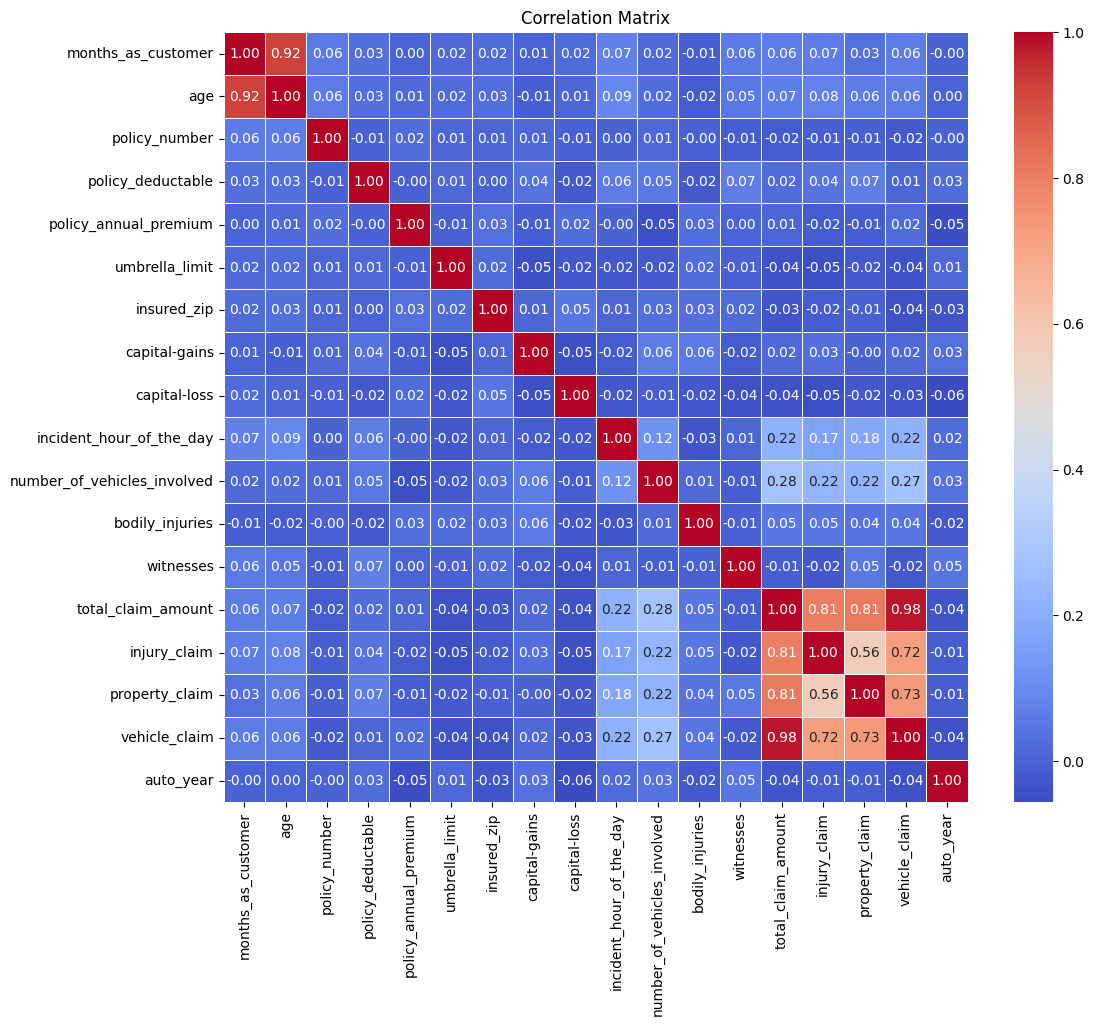

In [10]:
# Correlation Analysis for numeric_df is the DataFrame
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix including the target variable
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

The strong positive correlations between Total Claim Amount (TCA) and various types of claims (injury, property, vehicle) reveal that higher values in 
one type of claim tend to correspond with higher values in the other types of claim. This insight could prompt 
further investigation into the factors driving these correlations, such as common causes of claims or customer behaviors.

The correlation between Month as Customer and age suggests a relationship between the length of time a customer has been with the 
insurance company and their age. This insight could lead to hypotheses about customer retention, loyalty, or demographic trends.

The weak correlations between TCA and Incident Hour of the Day and Number of Vehicles Involved are also indicate that these 
factors may have less influence on the total claim amount compared to other variables in the dataset. 

Rows with outliers:
     months_as_customer  age  policy_number policy_bind_date policy_state  \
30                  166   37         666333       19-06-2008           IL   
47                  175   34         866931       07-01-2008           IN   
87                   31   36         679370       15-08-1999           IL   
114                 258   46         648397       09-03-1999           IN   
118                 245   39         531640       21-04-2001           OH   
228                 154   37         241562       28-01-2010           IL   
247                 101   27         326322       10-02-2007           IL   
261                 232   43         751905       16-05-2001           OH   
313                  91   30         515217       18-06-2010           IL   
429                 264   47         687639       07-03-2005           IN   
457                 347   51         343421       18-10-1996           OH   
499                   1   29         357949       24-05-

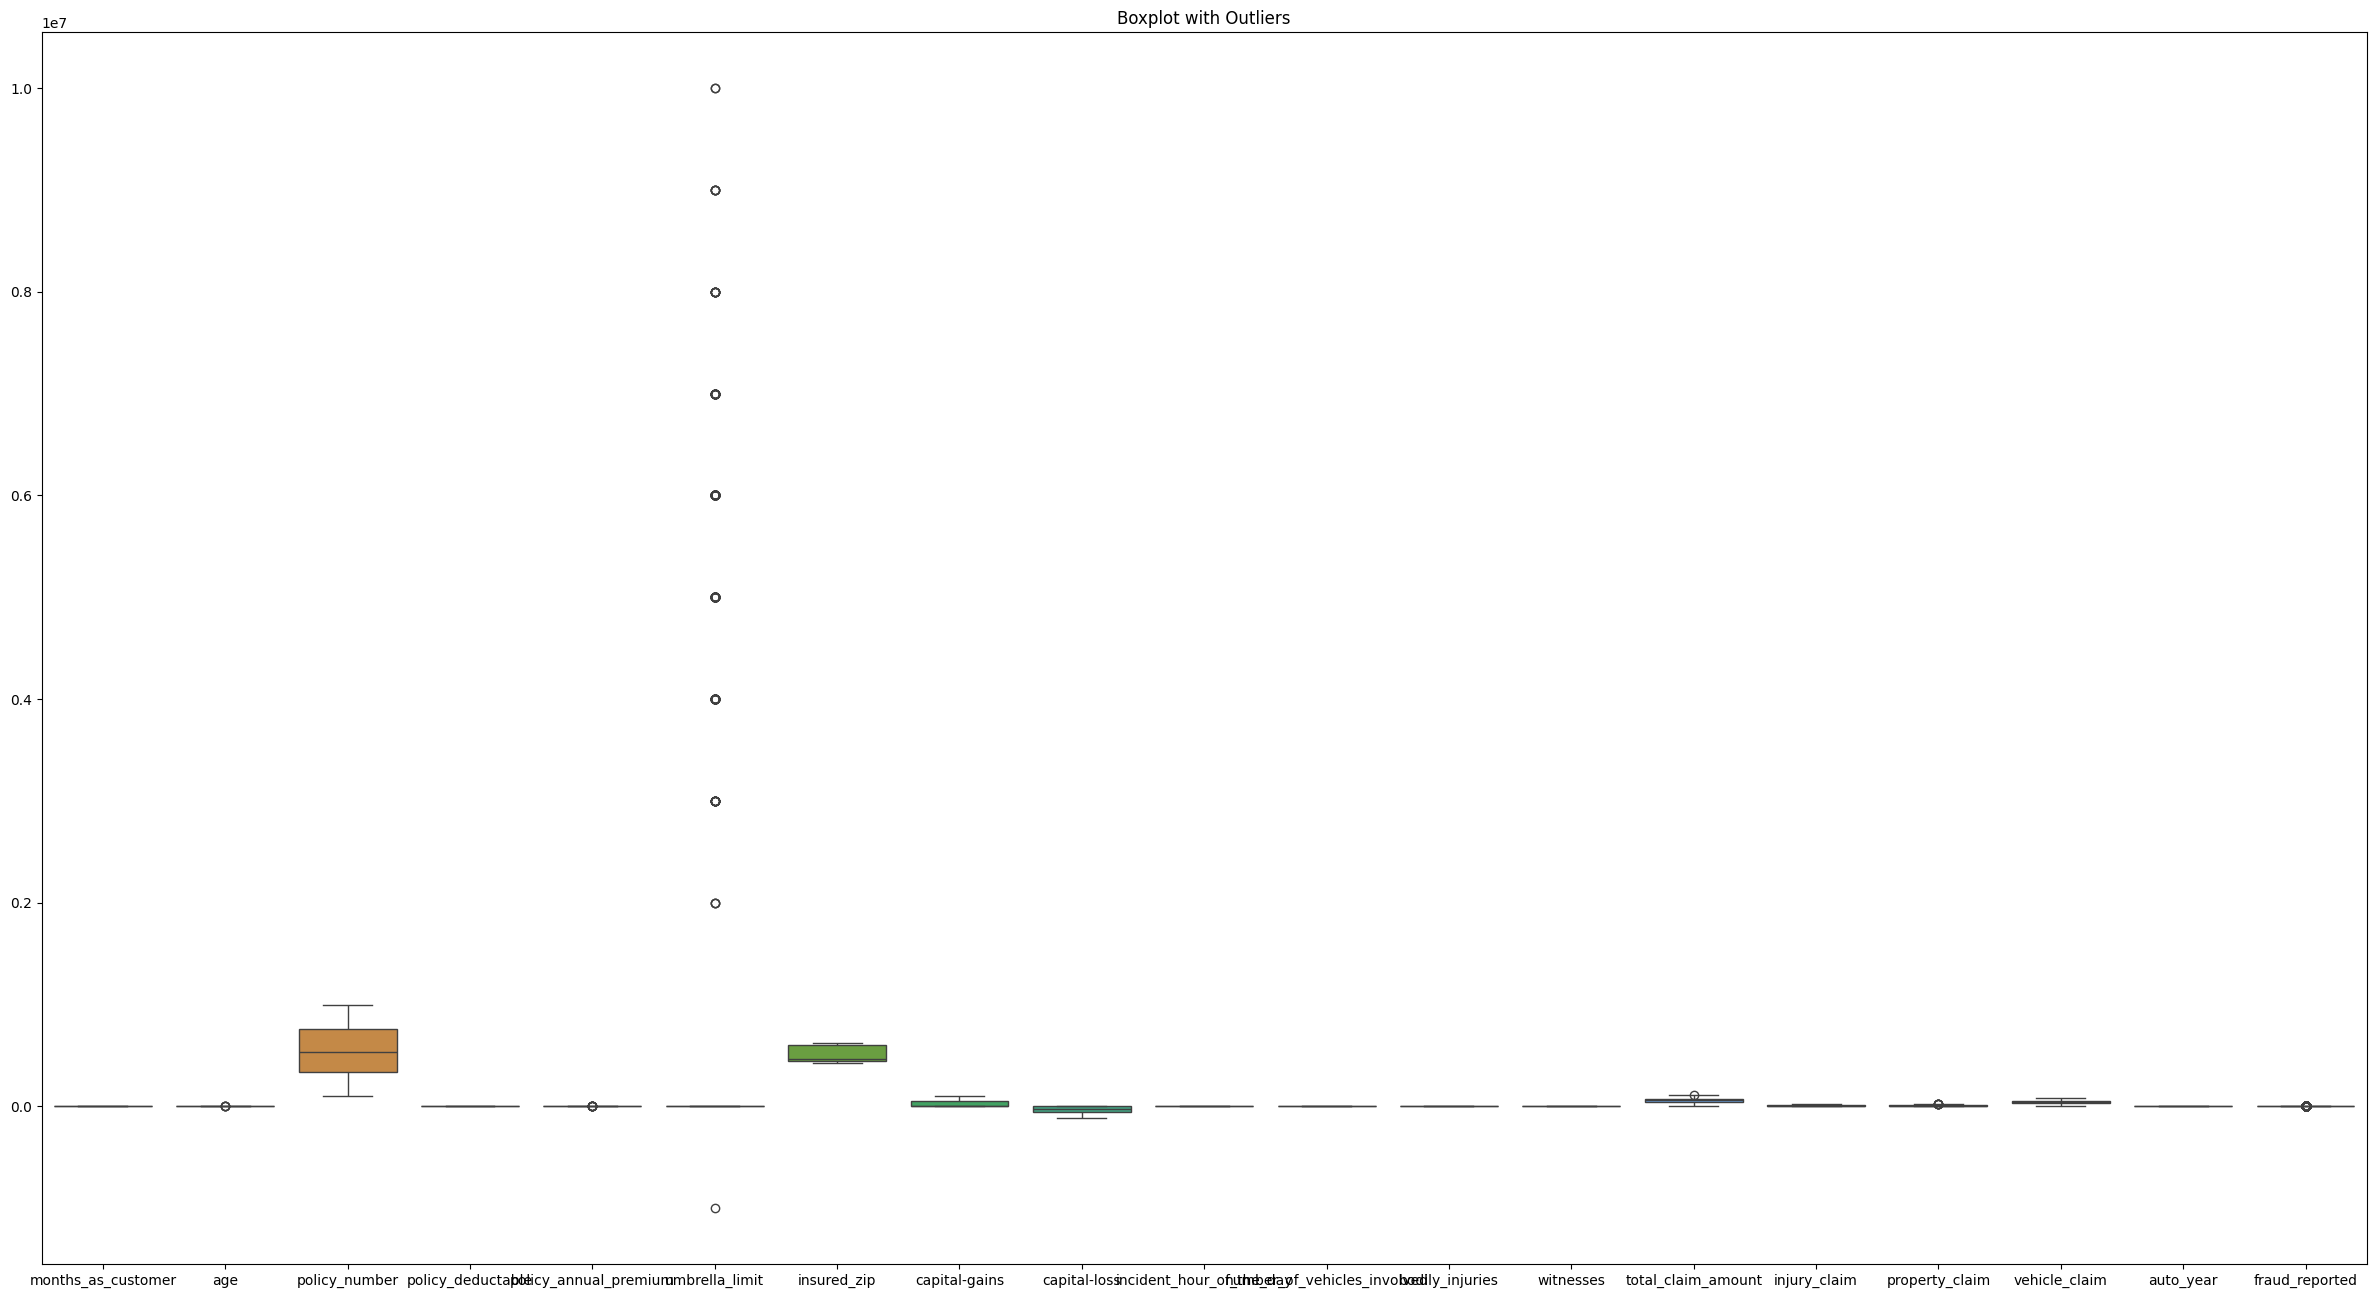

In [10]:
# Identifying Outliers

# Calculate z-scores for each data point
z_scores = ((numeric_df - numeric_df.mean()) / numeric_df.std()).abs()

# Define threshold for outliers (if z-score greater than 3)
outlier_threshold = 3

# Identify outliers using the z-score method
outlier_conditions = (z_scores > outlier_threshold)

# Display rows containing outliers
outliers = df[outlier_conditions.any(axis=1)]
print("Rows with outliers:")
print(outliers)

# Visualize the outliers using a boxplot
plt.figure(figsize=(30, 16))  
sns.boxplot(data=df) 
plt.title("Boxplot with Outliers")
plt.show()


Addressing outliers in umbrella_limit and property_claim is a priority as total_claim_amount, yet I plan to employ log transformation to mitigate their impact on the model.

In [17]:
# Suppress the warning
warnings.filterwarnings("ignore", message="divide by zero encountered in scalar divide")

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_df.columns

# Calculate VIF for each predictor variable
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]

# Print the VIF DataFrame
print(vif_data)

                       Variable         VIF
0            months_as_customer   28.002793
1                           age  129.982931
2                 policy_number    5.547568
3             policy_deductable    4.546599
4         policy_annual_premium   27.740650
5                umbrella_limit    1.239508
6                   insured_zip   50.344338
7                 capital-gains    1.840723
8                  capital-loss    1.936937
9      incident_hour_of_the_day    4.070629
10  number_of_vehicles_involved    4.679988
11              bodily_injuries    2.491279
12                    witnesses    2.851952
13           total_claim_amount         inf
14                 injury_claim         inf
15               property_claim         inf
16                vehicle_claim         inf
17                    auto_year  135.384203


I plan to employ log transformation on variable with VIF that is greater than 10 to mitigate their impact on the model. I may be drop injury, property 
and vehicle claim when modelling. 

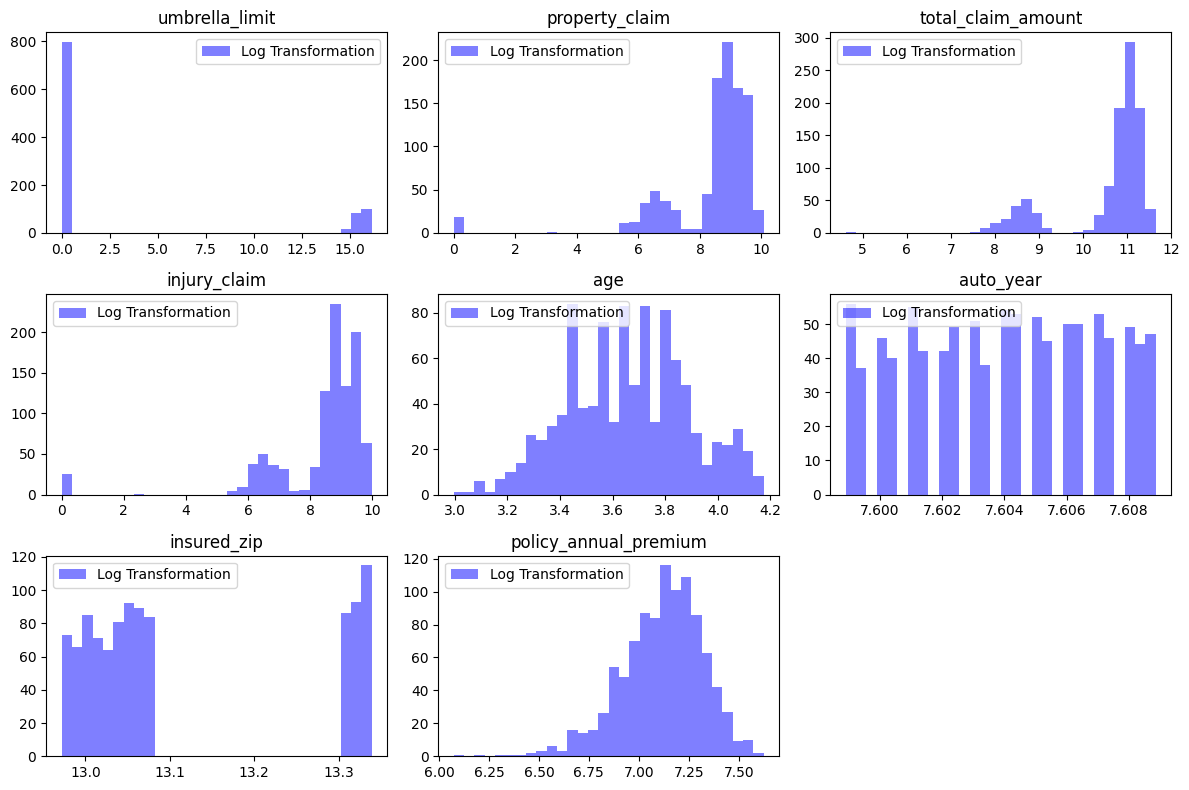

In [8]:
# Suppress the warning
warnings.filterwarnings("ignore", message="invalid value encountered in log")
# Handling outliers
# Step 1: Identify Variables with Outliers
outlier_vars = ['umbrella_limit', 'property_claim', 'total_claim_amount', 'injury_claim', 'age','auto_year' ,'insured_zip','policy_annual_premium']

# Step 2: Apply Logarithmic Transformation
# Logarithmic Transformation
log_transformed_vars = df[outlier_vars].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0) issues

# Replace the original columns with the transformed columns
df[outlier_vars] = log_transformed_vars  

# Visualize the transformed data
plt.figure(figsize=(12, 8))
for i, col in enumerate(outlier_vars):
    plt.subplot(3, 3, i+1)
    plt.hist(log_transformed_vars[col], bins=30, alpha=0.5, color='blue', label='Log Transformation')
    plt.legend()
    plt.title(col)
plt.tight_layout()
plt.show()


In [17]:
# PCA Analysis
from sklearn.decomposition import PCA

# Set the random seed
np.random.seed(123) 

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Transform the data into the principal components
pca_data = pca.transform(scaled_data)

# Extracting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# df_columns is a list of column names in the df1 DataFrame
df_columns = numeric_df.columns.tolist()

# Create a DataFrame to store the variable loadings for each principal component
loadings_df = pd.DataFrame(pca.components_, columns=df_columns)

# Print the variable loadings for each principal component
for i in range(loadings_df.shape[0]):
    print(f"Principal Component {i+1} Loadings:")
    print(loadings_df.iloc[i].sort_values(ascending=False))
    print()
# Create a DataFrame to examine the principal components
pca_df = pd.DataFrame(data=pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])

# Visualize the explained variance ratio
print("Explained Variance Ratio:", explained_variance_ratio)

Principal Component 1 Loadings:
total_claim_amount             0.520617
vehicle_claim                  0.499494
property_claim                 0.444890
injury_claim                   0.443703
number_of_vehicles_involved    0.198584
incident_hour_of_the_day       0.164048
age                            0.086187
months_as_customer             0.078955
policy_deductable              0.033891
bodily_injuries                0.031595
capital-gains                  0.016185
witnesses                      0.001746
policy_annual_premium         -0.002537
policy_number                 -0.006388
insured_zip                   -0.015223
auto_year                     -0.015467
capital-loss                  -0.028953
umbrella_limit                -0.029783
Name: 0, dtype: float64

Principal Component 2 Loadings:
months_as_customer             0.692018
age                            0.691266
policy_number                  0.090432
witnesses                      0.085635
incident_hour_of_the_day       

The loadings of principal components represent the contribution of each variable to the overall variance in the data. In this predictive model, 
variables with higher absolute loadings on the first principal component, such as Total Claim Amount, Vehicle Claim, Property Claim, and Injury Claim,
are more influential in explaining the variation in the dataset and play significant roles in predicting outcomes. This variable will contribute
significantly to the predictive power of the model. Also, understanding these loadings helps prioritize features and refine the model for better 
accuracy in predicting outcomes related to insurance claims.

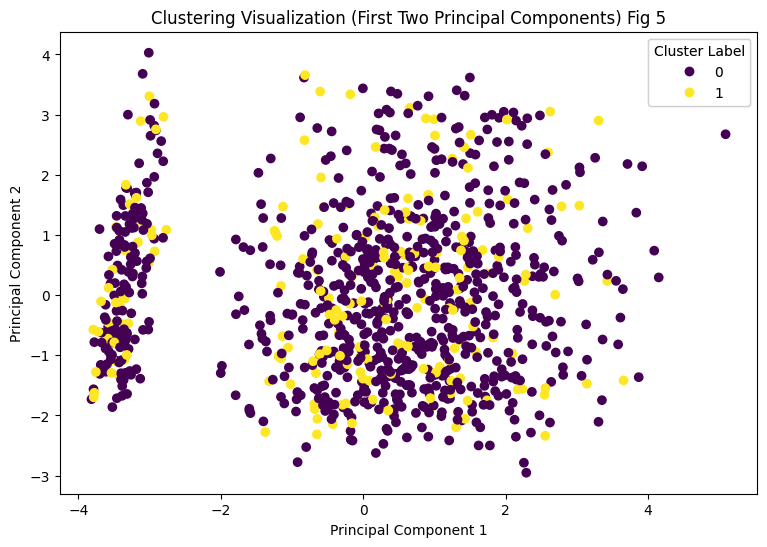

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings("ignore", message=".*deprecated.*")

# Explicitly set the value of n_init to suppress the warning
kmeans = KMeans(n_clusters=2, n_init=10)
labels = kmeans.fit_predict(numeric_df)

# Create a scatter plot of the first two principal components
plt.figure(figsize=(9, 6))
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.title('Clustering Visualization (First Two Principal Components) Fig 5')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster Label")
plt.gca().add_artist(legend1)

plt.show()


Cluster centers:
 [[-2.93491664  0.2115379 ]
 [ 0.84828558 -0.06114128]]


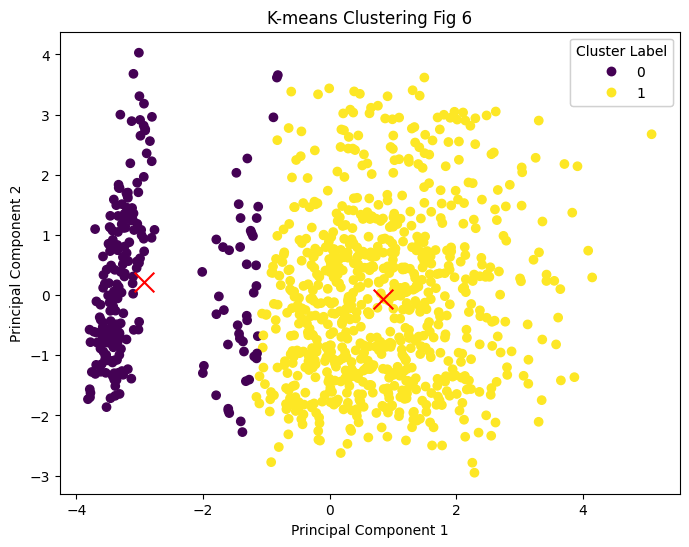

In [48]:
# Set the random seed
np.random.seed(123)
# Importing necessary libraries
from sklearn.cluster import KMeans

k_data = pca_data[:, :2]
# Ignoring warnings
warnings.filterwarnings("ignore")

# Creating a KMeans instance
kmeans = KMeans(n_clusters=2) 

# Fitting the KMeans model to the data
kmeans.fit(k_data)

# Getting the cluster centers
cluster_centers = kmeans.cluster_centers_

# Getting the cluster labels for each data point
labels = kmeans.labels_

# Printing the cluster centers and labels
print("Cluster centers:\n", cluster_centers)

# Plotting the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(k_data[:, 0], k_data[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='red', s=200)  # Plotting centroids
plt.title('K-means Clustering Fig 6')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster Label")
plt.gca().add_artist(legend1)

plt.show()

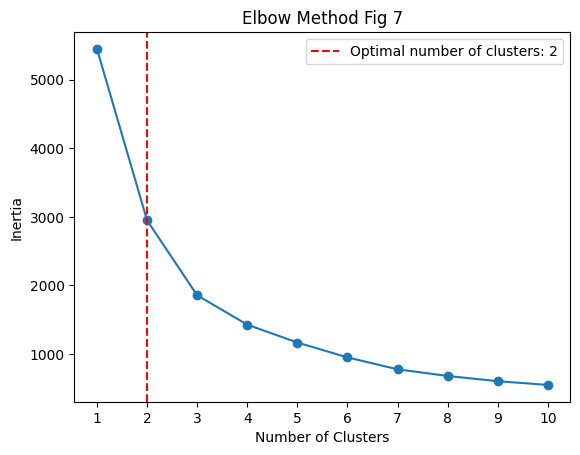

Optimal number of clusters suggested by the elbow method: 2


In [46]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set the random seed
np.random.seed(123)

# Assuming pca_data is a NumPy array
k_data = pca_data[:, :2]

# Define the range of clusters to evaluate
num_clusters_range = range(1, 11)

# Initialize list to store the inertia values
inertia_values = []

# Calculate inertia for each number of clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(k_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(num_clusters_range, inertia_values, marker='o')
plt.title('Elbow Method Fig 7')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(num_clusters_range)

# Find the "elbow" point where inertia starts to decrease at a slower rate
delta_inertia = np.diff(inertia_values)
optimal_num_clusters_index = np.where(delta_inertia < np.mean(delta_inertia))[0][0] + 1
optimal_num_clusters = num_clusters_range[optimal_num_clusters_index]

# Mark the optimal number of clusters on the plot
plt.axvline(x=optimal_num_clusters, color='red', linestyle='--', label=f'Optimal number of clusters: {optimal_num_clusters}')
plt.legend()

plt.show()

print("Optimal number of clusters suggested by the elbow method:", optimal_num_clusters)


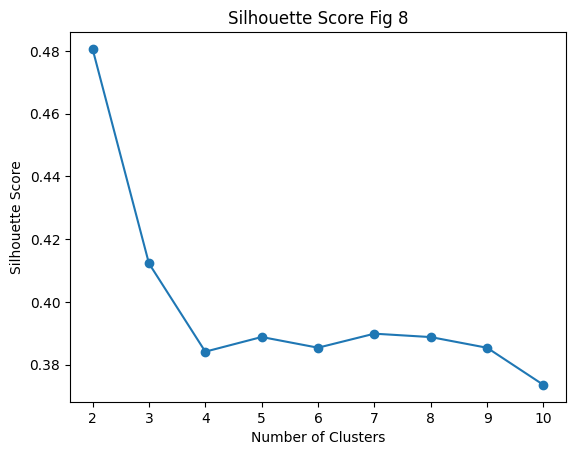

Optimal number of clusters suggested by the silhouette score: 2


In [47]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Set the random seed
np.random.seed(123)

# Assuming pca_data is a NumPy array
k_data = pca_data[:, :2]

# Define the range of clusters to evaluate
num_clusters_range = range(2, 11)

# Initialize list to store silhouette scores
silhouette_scores = []

# Calculate silhouette score for each number of clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(k_data)
    silhouette_scores.append(silhouette_score(k_data, labels))

# Plot silhouette scores
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score Fig 8')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(num_clusters_range)
plt.show()

# Find the optimal number of clusters with maximum silhouette score
optimal_num_clusters = num_clusters_range[np.argmax(silhouette_scores)]

print("Optimal number of clusters suggested by the silhouette score:", optimal_num_clusters)


Fig 5: Distinct Cluster
This cluster likely represents a group of loyal or long-standing customers who may have distinct service or product needs compared to the more diverse 
spread cluster. It could also encompass policyholders exhibiting similar traits, potentially including behaviours associated with fraudulent activity. 
The proximity to the PCA2 axis suggests a strong correlation with features like months_as_customer and age.

Overlapping Clusters
The two clusters partially overlap, indicating insurance claims with moderate values of Principal Component 1. This mix suggests varying degrees of 
total claim amounts, vehicle claims, property claims, and injury claims, representing a wider range of insurance cases with differing levels of 
severity and complexity.

Fig 6: Spread Cluster and KMeans Centroids
The spread-out nature of this cluster across the plot suggests varying values for both PCA1 and PCA2, indicating weaker correlations with the principal
components compared to the distinct cluster. Additionally, the KMeans algorithm successfully identified centroids for the clusters, allowing for the 
characterization of each cluster's central tendency. This information can aid in understanding the distinctiveness of each group and potentially assist
in identifying fraudulent behaviour.

Fig 7 & 8: Elbow Method and Silhouette Score
The agreement between the elbow method and silhouette score, suggesting two clusters, supports the idea of two distinct groups within the data.

In summary, the PCA1 & 2 and KMeans analysis indicate that claims involving customers with longer tenure, older ages, higher policy numbers, and more 
witnesses tend to occur together. Consequently, claims that deviate from this pattern may be flagged as potential fraud cases. These findings provide 
valuable insights into customer segmentation, fraud detection, and risk management strategies in the insurance industry, highlighting the importance 
of data-driven approaches in understanding customer behaviour and enhancing business outcomes.

In [21]:

from sklearn.impute import SimpleImputer
# Set the random seed
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X = df[['months_as_customer', 'age', 'policy_number', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year']]  # Features (excluding categorical columns)
X_categorical = pd.get_dummies(df[['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', '1ncident_location', 'property_damage', 'police_report_available', 'auto_make', 'auto_model']])  # One-hot encode categorical columns
X = pd.concat([X, X_categorical], axis=1)  # Combine numerical and encoded categorical features
y = df['fraud_reported']

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit and transform the scaled features

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)


# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Impute missing values in both training and testing sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize RandomForestRegressor
random_forest = RandomForestRegressor()

# Fit the model on the imputed training data
model = random_forest.fit(X_train_imputed, y_train)


# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top N important features
print("Top 15 Important Features:")
print(feature_importance_df.head(15))
print("=" * 50)

# Make predictions on test set
y_pred = random_forest.predict(X_test)

# Evaluate the regressor
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print results
print("Regressor: RandomForestRegressor")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r_squared:.4f}")
print("=" * 50)


Top 15 Important Features:
                             Feature  Importance
1091  incident_severity_Major Damage    0.272268
1002           insured_hobbies_chess    0.139165
1003       insured_hobbies_cross-fit    0.077328
6                        insured_zip    0.026208
2                      policy_number    0.019887
14                      injury_claim    0.015610
4              policy_annual_premium    0.015463
15                    property_claim    0.015344
0                 months_as_customer    0.011903
9           incident_hour_of_the_day    0.010258
1                                age    0.009846
7                      capital-gains    0.009149
16                     vehicle_claim    0.009090
17                         auto_year    0.008609
13                total_claim_amount    0.008537
Regressor: RandomForestRegressor
Mean Squared Error: 0.1175
R-squared: 0.2656


The rationale for selecting variables for modelling is based on a comprehensive analysis encompassing correlation, Variance Inflation Factor (VIF) Principal Component Analysis (PCA), and RandomForestRegressor (RFR) feature importance. These methods collectively provide insights into the relationships between variables, their contribution to reducing dimensionality, and their predictive power in the context of the model. By considering these factors, informed decisions can be made regarding which variables are most relevant and impactful for inclusion in the modelling process. This approach ensures that the selected variables not only capture the underlying patterns in the data but also enhance the model's ability to generalize and make accurate predictions.

In [9]:
# Set the random seed
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
Xi = df[['total_claim_amount', 'number_of_vehicles_involved', 'incident_hour_of_the_day', 'age', 'months_as_customer', 'policy_deductable', 'bodily_injuries', 'capital-gains', 'witnesses', 'policy_annual_premium', 'policy_number', 'insured_zip', 'auto_year', 'capital-loss', 'umbrella_limit']]  # Features (excluding categorical columns)
X_categoricali = pd.get_dummies(df[['policy_bind_date', 'policy_state', 'insured_education_level', 'insured_occupation', 'insured_hobbies',  'incident_type', 'incident_severity', 'authorities_contacted', 'incident_state', '1ncident_location', 'property_damage', 'police_report_available']])  # One-hot encode categorical columns
Xi = pd.concat([Xi, X_categoricali], axis=1)  # Combine numerical and encoded categorical features
yi = df['fraud_reported']

# Standardize features 
scaleri = StandardScaler()
X_scaledi = scaleri.fit_transform(Xi)  # Fit and transform the scaled features

# Split the dataset into training (80%) and testing (20%) sets
X_traini, X_testi, y_traini, y_testi = train_test_split(X_scaledi, yi, test_size=0.2)


In [10]:
# Checking for imbalance in the datasets.)
yi.value_counts()

fraud_reported
0    753
1    246
Name: count, dtype: int64

In [11]:
# Initialize SMOTE ( to address the class imbalance in the datasets.)
sm = SMOTE()

# Create a SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like median or mode

# Fit and transform the data to impute missing values
Xi_imputed = imputer.fit_transform(Xi)

# The implementation of the fit_resample 
Xi_resampled, yi_resampled = sm.fit_resample(Xi_imputed, yi)

# Create a DataFrame to see the distribution of classes in the target vector yi
data = pd.concat([pd.DataFrame(Xi_resampled, columns=Xi.columns), pd.Series(yi_resampled, name=yi.name)], axis=1)
class_distribution = data[yi.name].value_counts()

print(class_distribution)

fraud_reported
1    753
0    753
Name: count, dtype: int64


In [47]:
# Set the random seed
np.random.seed(123)

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize classifiers
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
logistic_regression = LogisticRegression()
support_vector_machine = SVC()
xgboost_classifier = xgb.XGBClassifier(reg_alpha=0.1, reg_lambda=0.1, missing=np.nan)  # Specify missing value

# Create a list of classifiers
classifiers = [random_forest, xgboost_classifier, gradient_boosting, logistic_regression, support_vector_machine]

# Define an imputer to handle missing values
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like median or mode

# Impute missing values in Xi
Xi_imputed = imputer.fit_transform(Xi)

# Perform k-fold cross-validation for each classifier
for clf in classifiers:
    # Perform 10-fold cross-validation
    scores = cross_val_score(clf, Xi_imputed, yi, cv=10, scoring='accuracy')
    
    # Print the results
    print(f"Classifier: {clf.__class__.__name__}")
    print(f"Accuracy: {scores.mean():.4f} +/- {scores.std():.4f}")
    print("="*50)


Classifier: RandomForestClassifier
Accuracy: 0.7577 +/- 0.0175
Classifier: XGBClassifier
Accuracy: 0.8319 +/- 0.0408
Classifier: GradientBoostingClassifier
Accuracy: 0.8409 +/- 0.0304
Classifier: LogisticRegression
Accuracy: 0.7538 +/- 0.0046
Classifier: SVC
Accuracy: 0.7538 +/- 0.0046


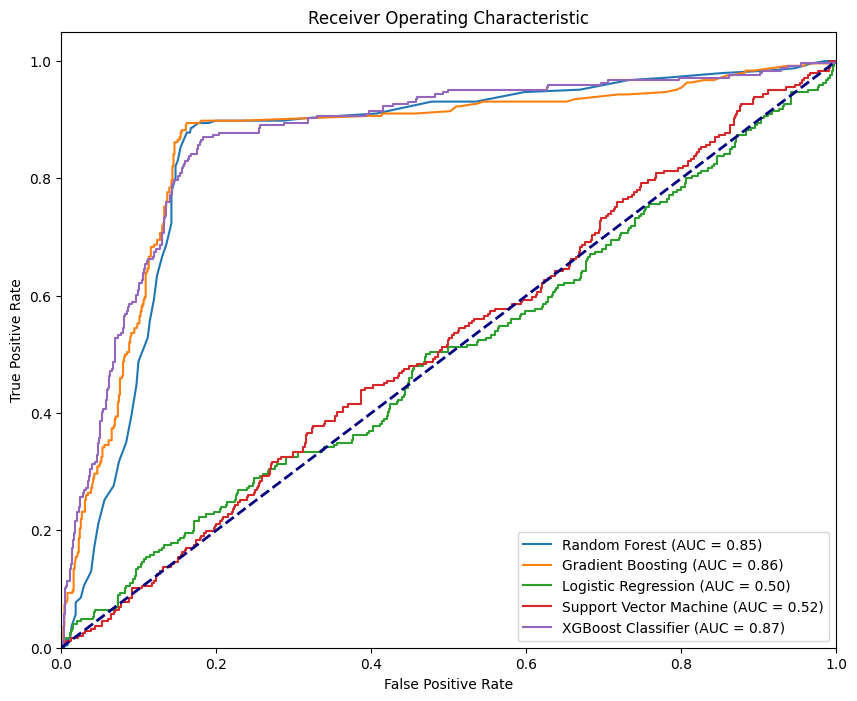

In [51]:
# Define an imputer to handle missing values
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like median or mode

# Impute missing values in Xi
Xi_imputed = imputer.fit_transform(Xi)

plt.figure(figsize=(10, 8))

# Perform k-fold cross-validation for each classifier
for name, clf in classifiers:
    y_prob = cross_val_predict(clf, Xi_imputed, yi, cv=10, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(yi, y_prob)  # Use yi instead of y here
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot attributes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Set the random seed
np.random.seed(123)

# Define pipeline with imputation and gradient boosting
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('gb', HistGradientBoostingClassifier())  # Use HistGradientBoostingClassifier
])

# Define the parameter grid for GradientBoostingClassifier
param_grid = {
    'gb__learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'gb__max_depth': [3, 4, 5],  # Maximum depth of the individual estimators
    'gb__min_samples_leaf': [1, 2, 3],  # Minimum number of samples required to be at a leaf node
    'gb__max_bins': [100, 150, 200]  # Maximum number of bins
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_traini, y_traini)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_testi)
accuracy = accuracy_score(y_testi, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")


Best parameters found:
{'gb__learning_rate': 0.05, 'gb__max_bins': 150, 'gb__max_depth': 4, 'gb__min_samples_leaf': 1}
Accuracy on Test Set: 0.8350


In [13]:
joblib.dump(best_model, 'Insurance_ClaimFraud_Detection.joblib')

['Insurance_ClaimFraud_Detection.joblib']

In conclusion, the thorough examination of various insurance-related factors reveals essential insights crucial for informed decision-making in the 
insurance sector. Through meticulous analysis of claim amounts, incident timing, age demographics, and fraud indicators, we gain a nuanced understanding
of customer behavior and risk patterns. These insights, complemented by advanced analytical techniques such as PCA and cluster analysis, empower us to 
optimize customer segmentation, enhance fraud detection mechanisms, and refine risk management strategies. By integrating these findings with a 
finely-tuned HistGradientBoostingClassifier, we bolster predictive accuracy and pave the way for data-driven excellence in insurance operations, 
ensuring sustainable growth and robust risk mitigation in the dynamic insurance landscape.